# What waveforms can tell us about induced seismic sources<br/>

In this notebook, we look into the so-called *moment tensor* (MT) description of a seismic source. The moment tensor is a three by three tensor containing six independent parameters. **Moment tensor representations of seismic sources are particulary useful because they linearise the *forward problem* of seismic wave excitation.** Furthermore assuming the most simple subsurface (homogeneous, isotropic and losslesss), we briefly investigate the effect of the moment tensor on the waveforms recorded at the Earth's surface. The assumptions regarding the medium imply that the so-called Green's functions, which contain the subsurface' response to a point source, can be computed analytically. Specifically, they are uniquely determined by the density, P-wave velocity, and S-wave velocity of the subsurface.


<!--The analytical Green's displacement vector due to a (moment tensor) point source in such a medium is explicitly derived in Aki & Richards (2002) and given in equation 4.29. The investigation of the different sampling strategies focussses on so-called Piecewise deterministic Processes (PDPs). -->

## The forward problem

In the context of induced seismicity, time-dependent surface displacement is generally recorded by arrays of three-component surface seismometers. Let us denote the recorded surface displacement by $\mathbf{u}$ (a vector quantity) and the seismometer location by $\mathbf{x}$. Assuming the displacement to be accurate at periods for which the induced seismic source is effectively a point source, $\mathbf{u}$ can be expressed as a temporal convolution between the spatial derivative (with respect to the source coordinates $\boldsymbol{\xi}=(\xi_1,\xi_2,\xi_3)$) of the elastic *Green's function* $\mathbf{G}$ and the moment tensor $\mathbf{M}$. Mathematically, this can be written as
$$
u_{n}(\mathbf{x},t)=\sum_{p=1}^{3} \sum_{j=1}^{3} G_{n p, j}(\mathbf{x},t;\boldsymbol{\xi}^{(0)},0) * M_{p j}(\boldsymbol{\xi}^{(0)},t),
$$
where the subscripts $n$, $p$ and $j$ take on values 1, 2, or 3 and are associated with the $x_1$, $x_2$ and $x_3$ coordinate axes. The comma denotes spatial differentiation. Often, a local geographic coordinate system is used to define a Cartesian system tensor, with positive $x_1$ being northward, positive $x_2$ eastward, and positive $x_3$ being downward (NED). <!--Above, Einstein's summation convention applies and hence the right-hand side contains an implicit summation over 9 components of the moment tensor.-->

### The Green's function

Although often referred to as the Green's "function", the wavefield at $\mathbf{x}$ due to an impulsive source at $\boldsymbol{\xi}^{(0)}$ is effectively represented by a nine-component tensor: for each of the unidirectional impulsive (delta function) forces (one in each of the three Cartesian directions) at $\boldsymbol{\xi}^{(0)}$, the wavefield at $\mathbf{x}$ has three components ($u_1$, $u_2$, and $u_3$). **A medium's Green's function captures all wave-propagation related physics between source and receiver.** Obviously, an accurate velocity model is required in order to accurately compute Green's functions. Inaccurate velocity models can be a major limitation when it comes to seismic source characterization. 

<br>
<center>
    <figure style="width700px;">
        <img src="greens_function.png"/>
        <figcaption><i>Example of a Green's function computed for the velocity model below Groningen. The impulsive source is is located at the left and the wavefield is (in this case) "recorded" in the middle of the Groningen gas reservoir</i></figcaption>
    </figure>
</center>



### Moment magnitude

We mentioned above that at sufficiently long periods, a seismic source can be represented by a so-called moment tensor. The moment tensor description of a seismic source effectively collapses this source to a single point in the subsurface (point source assumption). The moment tensor is symmetric, and hence has six independent elements. The so-called *scalar moment* provides an estimate of the strenght of a seismic source (Silver & Jordan, 1982):
$$
M_{0} \equiv \sqrt{\sum_{i=1}^{3} \sum_{j=1}^{3} M_{ij}^{2}}/\sqrt{2}
$$

Importantly, Kanamori (1977) based a magnitude scale on the seismic moment of an earthquake. This magnitude is referred to as the *moment magnitude*, and is usually denoted by $M_W$. It is the only physics-based earthquake magnitude scale and therefore fundamentally different from empirical magnitude scales such as Richter's magnitude scale (which is usually referred to as the local magnitude and denoted by $M_L$). The moment magnitude is related to $M_0$ by (Kanamori, 1977),
$$
log(M_0) = 1.5 M_W + 9.1.
$$


### Strike, dip, and rake

Often, a local geographic coordinate system is used to define a Cartesian system tensor, with positive $x_1$ being northward, positive $x_2$ eastward, and positive $x_3$ being downward (NED). The NED coordinate system is used below to derive relations between the angles of a ruptured fault (strike and dip angle) and the dislocation direction on the rupture plane (rake angle). The strike, dip, and rake are denoted by $\varphi$, $\delta$, and $\lambda$, respectively, and are defined as follows:
* Strike ($\varphi$) is defined as the clockwise angle of the fault from North (positive $x_1$)
* Dip ($\delta$) is defined as the angle with the horizontal plane, in a direction 90 degrees clockward of strike.
* Rake ($\lambda$) gives the direction of relative displacement along fault and is defined as the angle, counterclockwise, with respect to the strike. 0 < rake < 180 therefore means that the there is a component of thrust faulting, whereas -180 < rake < 0 implies a component of normal faulting

<center>
    <figure style="width:600px;">
        <img src="strike_dip_rake.png"/>
        <figcaption><i>Example of an oblique thrust fault with a strike of 90 degrees. </i></figcaption>
    </figure>
</center>



<center>
    <figure style="width:800px;">
        <img src="Kuhn_et_al_table.png"/>
        <figcaption><i>Inversion results of Kuhn et al (2020). These parameters correspond to induced events in the Groningen Gas field. The parameters in the red box are associated with the $M_L$ 3.4 event close to Westerwijtwerd.</i></figcaption>
    </figure>
</center>

<br><span style="font-size:1.5em;">*Import all necessary modules*</span>

In [1]:
# Please run it before you start the simulation!
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, arccos, arctan,  pi, sign, sqrt
from numpy import vectorize, linspace, asarray, outer, diff, savetxt
import pandas as pd
pd.set_option('display.float_format', '{:.3g}'.format)
from pyrocko import moment_tensor as pmt
from pyrocko import util
from pyrocko.plot import beachball
from pyrocko import plot
from scipy.special import erf
from scipy.integrate import quad


<br><span style="font-size:1.5em;">*Setting the stage*</span>

In [2]:
# Moment Magnitude of the earthquake(Mw)
magnitude = 2.5  

# Orientation of the fault and direction of slip
strike = 180       # Strike is defined as the clockwise angle of the fault from North (positive x1)
dip = 90      # Dip is defined as the angle with the horizontal plane, 
                 # in a direction 90 degrees clockward of strike.
rake = 180      # Rake gives the direction of relative displacement along fault and defined as the 
                 # angle, counterclockwise, with respect to the strike. 0 < rake < 180 therefore means
                 # that the there is a component of thrust faulting, whereas -180 < rake < 0 implies
                 # a component of normal faulting

# Source time function
#stf = 'gauss'             # Set the desired source time function 'heaviside' , 'gauss error function'
Trise = 0.01              # Rise time used in the source time function 

# Medium parameters
rho = 2500                # Density kg/m^3 
beta = 2000               # S-wave velocity
alpha = sqrt(3)*beta      # p-wave velocity

<br><span style="font-size:1.5em;">*Precompute variables*</span>

In [3]:
# Convert moment magnitude to moment based on Kanamori (1977); See Aki & Richards, eq. 3.17
M0=10**(1.5*magnitude+9.1)  

# Compute moment tensor components from strike, dip, rake and scalar moment
mt = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=M0)

m6 = [mt.mnn, mt.mee, mt.mdd, mt.mne, mt.mnd, mt.med]  # The six MT components
#print(m6/mt.scalar_moment())  # normalized MT components
### Define here the moment tensor
MOMT=np.zeros((3, 3))
MOMT[0,0]=mt.mnn/mt.scalar_moment()
MOMT[1,1]=mt.mee/mt.scalar_moment()
MOMT[2,2]=mt.mdd/mt.scalar_moment()
MOMT[0,1]=mt.mne/mt.scalar_moment()
MOMT[1,0]=mt.mne/mt.scalar_moment()
MOMT[0,2]=mt.mnd/mt.scalar_moment()
MOMT[2,0]=mt.mnd/mt.scalar_moment()
MOMT[1,2]=mt.med/mt.scalar_moment()
MOMT[2,1]=mt.med/mt.scalar_moment()

# Source time function times seismic moment 
stf = lambda t: M0*((1 + erf(t/Trise))/2)

# Calculate integrand of near-field term
integrand = lambda  tau, t: tau*stf(t - tau)

# Evaluate integral of near-field term
def integral(t):
    return quad(integrand, r/alpha, r/beta, args=(t))[0]

vec_integral = vectorize(integral)

<br><span style="font-size:1.5em;">*Moment tensor and focal mechanism (beach ball)*</span>

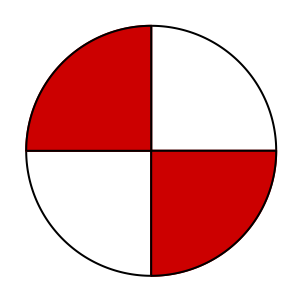

Moment tensor values:


,"$M_{1,j}$","$M_{2,j}$","$M_{3,j}$"
"$M_{i,1}$",-2.45e-16,-1,-6.12e-17
"$M_{i,2}$",-1,2.45e-16,1.22e-16
"$M_{i,3}$",-6.12e-17,1.22e-16,1.5e-32


In [4]:
fig = plt.figure(figsize=(4., 4.))
fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
axes = fig.add_subplot(1,1,1)
axes.set_xlim(0., 2.)
axes.set_ylim(0., 2.)
axes.set_axis_off()

beachball.plot_beachball_mpl(
            pmt.as_mt(mt),
            axes,
            beachball_type='full',
            size=250.,
            position=(1, 1),
            color_t=plot.mpl_color('scarletred2'),
            linewidth=2.0)

saveplot = False
plt.show()

print("Moment tensor values:")
Moment_Tensor = pd.DataFrame(MOMT, 
                             columns=['$M_{1,j}$','$M_{2,j}$','$M_{3,j}$'],
                             index=['$M_{i,1}$','$M_{i,2}$','$M_{i,3}$'],
                            )
display(Moment_Tensor)

<br><span style="font-size:1.5em;">*Assignment 1: Moment tensor and focal mechanism (beach ball)*</span>

For a seismic event with moment magnitude $M_W = 2.5$, investigate both moment tensor (numerical values) and focal mechanism (beachball). Do this for the following ruptures (strike, dip, and rake):

1. $\phi=180$,  $\delta=60$, and $\lambda=−90$,

2. $\phi=0$,  $\delta=30$,  𝑎𝑛𝑑 $\lambda=−90$,

3. $\phi=90$,  $\delta=90$,  𝑎𝑛𝑑 $\lambda=0$, 

4. $\phi=180$,  $\delta=90$,  𝑎𝑛𝑑 $\lambda=180$

What do you observe?

,Magnitude,Strike,Dip,Rake
Parameters,2.5,180,90,180


,"$M_{1,j}$","$M_{2,j}$","$M_{3,j}$"
"$M_{i,1}$",-2.45e-16,-1,-6.12e-17
"$M_{i,2}$",-1,2.45e-16,1.22e-16
"$M_{i,3}$",-6.12e-17,1.22e-16,1.5e-32


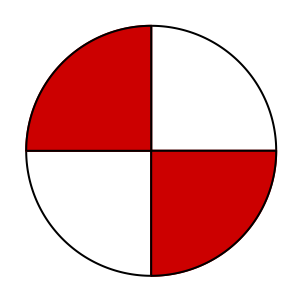

In [5]:
# You can use this function ;)
def moment_tensor(magnitude, strike, dip, rake):
    # Convert moment magnitude to moment based on Kanamori (1977); See Aki & Richards, eq. 3.17
    M0=10**(1.5*magnitude+9.1)  

    # Compute moment tensor components from strike, dip, rake and scalar moment
    mt = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=M0)

    m6 = [mt.mnn, mt.mee, mt.mdd, mt.mne, mt.mnd, mt.med]  # The six MT components
    ### Define here the moment tensor
    MOMT=np.zeros((3, 3))
    MOMT[0,0]=mt.mnn/mt.scalar_moment()
    MOMT[1,1]=mt.mee/mt.scalar_moment()
    MOMT[2,2]=mt.mdd/mt.scalar_moment()
    MOMT[0,1]=mt.mne/mt.scalar_moment()
    MOMT[1,0]=mt.mne/mt.scalar_moment()
    MOMT[0,2]=mt.mnd/mt.scalar_moment()
    MOMT[2,0]=mt.mnd/mt.scalar_moment()
    MOMT[1,2]=mt.med/mt.scalar_moment()
    MOMT[2,1]=mt.med/mt.scalar_moment()

    vec_integral = vectorize(integral)
    
    display(pd.DataFrame([[magnitude, strike, dip, rake]],
                         columns=["Magnitude", "Strike", 
                                  "Dip", "Rake"],
                         index=["Parameters"]))
    Moment_Tensor = pd.DataFrame(MOMT, 
                                 columns=['$M_{1,j}$','$M_{2,j}$','$M_{3,j}$'],
                                 index=['$M_{i,1}$','$M_{i,2}$','$M_{i,3}$'],
                                )
    display(Moment_Tensor)
    fig = plt.figure(figsize=(4., 4.))
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
    axes = fig.add_subplot(1,1,1)
    axes.set_xlim(0., 2.)
    axes.set_ylim(0., 2.)
    axes.set_axis_off()

    beachball.plot_beachball_mpl(
                pmt.as_mt(mt),
                axes,
                beachball_type='full',
                size=250.,
                position=(1, 1),
                color_t=plot.mpl_color('scarletred2'),
                linewidth=2.0)

    saveplot = False
    plt.show()

# Example:
moment_tensor(magnitude, strike, dip, rake)

In [6]:
# Solution 1 𝜑=180,  𝛿=60,  𝑎𝑛𝑑 𝜆=−90 


In [7]:
# Solution 2 𝜑=0,  𝛿=30,  𝑎𝑛𝑑 𝜆=−90 


In [8]:
# Solution 3 𝜑=90,  𝛿=90,  𝑎𝑛𝑑 𝜆=0 


In [9]:
# Solution 4 𝜑=180,  𝛿=90,  𝑎𝑛𝑑 𝜆=180 


<br><span style="font-size:1.5em;">*Radiation patterns: near (UN), intermediate (UIP, UIS), and far (UFP,UFS)*</span>

In [10]:
# Please run this cell to continue.
def compGN(gamma):
    GN= np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GN[i,j,k] = 15*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[k]
                if i==k:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[j]
                if j==k:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[i]
    return asarray(GN)

def compGIP(gamma):
    GIP = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GIP[i,j,k] = 6*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[k]
                if i==k:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[j]
                if j==k:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[i]
    return asarray(GIP)

def compGIS(gamma):
    GIS = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GIS[i,j,k] = 6*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GIS[i,j,k]=GIS[i,j,k] - 2*gamma[k]
                if i==k:
                    GIS[i,j,k]=GIS[i,j,k] - gamma[j]
                if j==k:
                    GIS[i,j,k]=GIS[i,j,k] - gamma[i]
    return asarray(GIS)

def compGFP(gamma):
    GFP = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GFP[i,j,k] = gamma[i]*gamma[j]*gamma[k]
    return asarray(GFP)

def compGFS(gamma):
    GFS = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GFS[i,j,k] = gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GFS[i,j,k]=GFS[i,j,k] - gamma[k]
    return asarray(GFS)

<br><span style="font-size:1.5em;">*Assignment 2: Seismic waveforms*</span>

In [13]:
from pyrocko.plot.automap import Map
from pyrocko.example import get_example_data
from pyrocko import model, gmtpy
from pyrocko import moment_tensor as pmt

gmtpy.check_have_gmt()

# Download example data
get_example_data('stations_deadsea.pf')
get_example_data('deadsea_events_1976-2017.txt')

# Generate the basic map
m = Map(
    lat=31.5,
    lon=35.5,
    radius=150000.,
    width=30., height=30.,
    show_grid=False,
    show_topo=True,
    color_dry=(238, 236, 230),
    topo_cpt_wet='light_sea_uniform',
    topo_cpt_dry='light_land_uniform',
    illuminate=True,
    illuminate_factor_ocean=0.15,
    show_rivers=False,
    show_plates=True)

# Draw some larger cities covered by the map area
m.draw_cities()

# Generate with latitute, longitude and labels of the stations
stations = model.load_stations('stations_deadsea.pf')
lats = [s.lat for s in stations]
lons = [s.lon for s in stations]
labels = ['.'.join(s.nsl()) for s in stations]

# Stations as black triangles. Genuine GMT commands can be parsed by the maps'
# gmt attribute. Last argument of the psxy function call pipes the maps'
# pojection system.
m.gmt.psxy(in_columns=(lons, lats), S='t20p', G='black', *m.jxyr)

# Station labels
for i in range(len(stations)):
    m.add_label(lats[i], lons[i], labels[i])


# Load events from catalog file (generated using catalog.GlobalCMT()
# download from www.globalcmt.org)
# If no moment tensor is provided in the catalogue, the event is plotted
# as a red circle. Symbol size relative to magnitude.

events = model.load_events('deadsea_events_1976-2017.txt')
beachball_symbol = 'd'
factor_symbl_size = 5.0
for ev in events:
    mag = ev.magnitude
    if ev.moment_tensor is None:
        ev_symb = 'c'+str(mag*factor_symbl_size)+'p'
        m.gmt.psxy(
            in_rows=[[ev.lon, ev.lat]],
            S=ev_symb,
            G=gmtpy.color('scarletred2'),
            W='1p,black',
            *m.jxyr)
    else:
        devi = ev.moment_tensor.deviatoric()
        beachball_size = mag*factor_symbl_size
        mt = devi.m_up_south_east()
        mt = mt / ev.moment_tensor.scalar_moment() \
            * pmt.magnitude_to_moment(5.0)
        m6 = pmt.to6(mt)
        data = (ev.lon, ev.lat, 10) + tuple(m6) + (1, 0, 0)

        if m.gmt.is_gmt5():
            kwargs = dict(
                M=True,
                S='%s%g' % (beachball_symbol[0], (beachball_size) / gmtpy.cm))
        else:
            kwargs = dict(
                S='%s%g' % (beachball_symbol[0],
                            (beachball_size)*2 / gmtpy.cm))

        m.gmt.psmeca(
            in_rows=[data],
            G=gmtpy.color('chocolate1'),
            E='white',
            W='1p,%s' % gmtpy.color('chocolate3'),
            *m.jxyr,
            **kwargs)

ExternalProgramMissing: GMT is not installed or cannot be found

Most important: in the cell below the heading "Assignment 2: Seismic waveforms", the seismic waveforms are computed for a single receiver. This needs to be computed for all receivers of the "luttelgeest array". The station locations should all be given relative to the event's location. You can keep 'r_z=-3000' for all stations, but 'r_x' and 'r_y' will of course be different for all stations. Do it such that the event is (more or less) located below the center of the seismic array. 

In [11]:
# Conventions: component 1 is positive North, component 2 positive East, and component 3 positive down.
# Vertical location of the receiver with respect to the Earthquake. 
# (The absolute value hence coincides with the depth of the earthquake).
r_z = -3000
# North and East coordinates of the receiver
r_n = 3000
r_e = 3000

# Distance
r = sqrt(r_n**2 + r_e**2 + r_z**2)

# Directional cosines
gamma = [r_n/r, r_e/r, r_z/r]

# Scalar factors in solution of Aki & Richards (Eq. 4.29; also eq. 4.32)
prefactor = 1/(4 * pi * rho)
CN  = prefactor/(r**4) 
CIP = prefactor/(alpha**2 * r**2)
CIS = prefactor/(beta**2 * r**2)
CFP = prefactor/(alpha**3 * r)
CFS = prefactor/(beta**3 * r)


GN = compGN(gamma)
UN = np.zeros(3)
for i in range(3):
        for j in range(3):
            UN[0]=UN[0]+GN[0,i,j]*MOMT[i,j]
            UN[1]=UN[1]+GN[1,i,j]*MOMT[i,j]
            UN[2]=UN[2]+GN[2,i,j]*MOMT[i,j]

GIP = compGIP(gamma)
UIP = np.zeros(3)
for i in range(3):
        for j in range(3):
            UIP[0]=UIP[0]+GIP[0,i,j]*MOMT[i,j]
            UIP[1]=UIP[1]+GIP[1,i,j]*MOMT[i,j]
            UIP[2]=UIP[2]+GIP[2,i,j]*MOMT[i,j]

GIS = compGIS(gamma)
UIS = np.zeros(3)
for i in range(3):
        for j in range(3):
            UIS[0]=UIS[0]+GIS[0,i,j]*MOMT[i,j]
            UIS[1]=UIS[1]+GIS[1,i,j]*MOMT[i,j]
            UIS[2]=UIS[2]+GIS[2,i,j]*MOMT[i,j]

GFP = compGFP(gamma)
UFP = np.zeros(3)
for i in range(3):
        for j in range(3):
            UFP[0]=UFP[0]+GFP[0,i,j]*MOMT[i,j]
            UFP[1]=UFP[1]+GFP[1,i,j]*MOMT[i,j]
            UFP[2]=UFP[2]+GFP[2,i,j]*MOMT[i,j]

GFS = compGFS(gamma)
UFS = np.zeros(3)
for i in range(3):
        for j in range(3):
            UFS[0]=UFS[0]+GFS[0,i,j]*MOMT[i,j]
            UFS[1]=UFS[1]+GFS[1,i,j]*MOMT[i,j]
            UFS[2]=UFS[2]+GFS[2,i,j]*MOMT[i,j]

# Multiplication with prefactors
UN=CN*UN
UIP=CIP*UIP
UIS=CIS*UIS 
UFP=CFP*UFP
UFS=CFS*UFS


# Minimum and maximum observation time 
tmin = r/alpha - 2*Trise
tmax = r/beta + Trise + 2*Trise  

t = linspace(tmin, tmax, 2000)
UNt=outer(UN,vec_integral(t))
UIPt = outer(UIP,stf(t-r/alpha))
UISt = outer(UIS,stf(t-r/beta))

t, dt = linspace(tmin, tmax, 2001, retstep=True)
UFPt = outer(UFP, diff(stf(t - r/alpha))/dt)
UFSt = outer(UFP, diff(stf(t - r/beta))/dt)

U = UNt + UIPt - UISt + UFPt - UFSt

t, dt = linspace(tmin, tmax, 2000, retstep=True)
V = np.zeros((3,2000))
V = diff(U)/dt



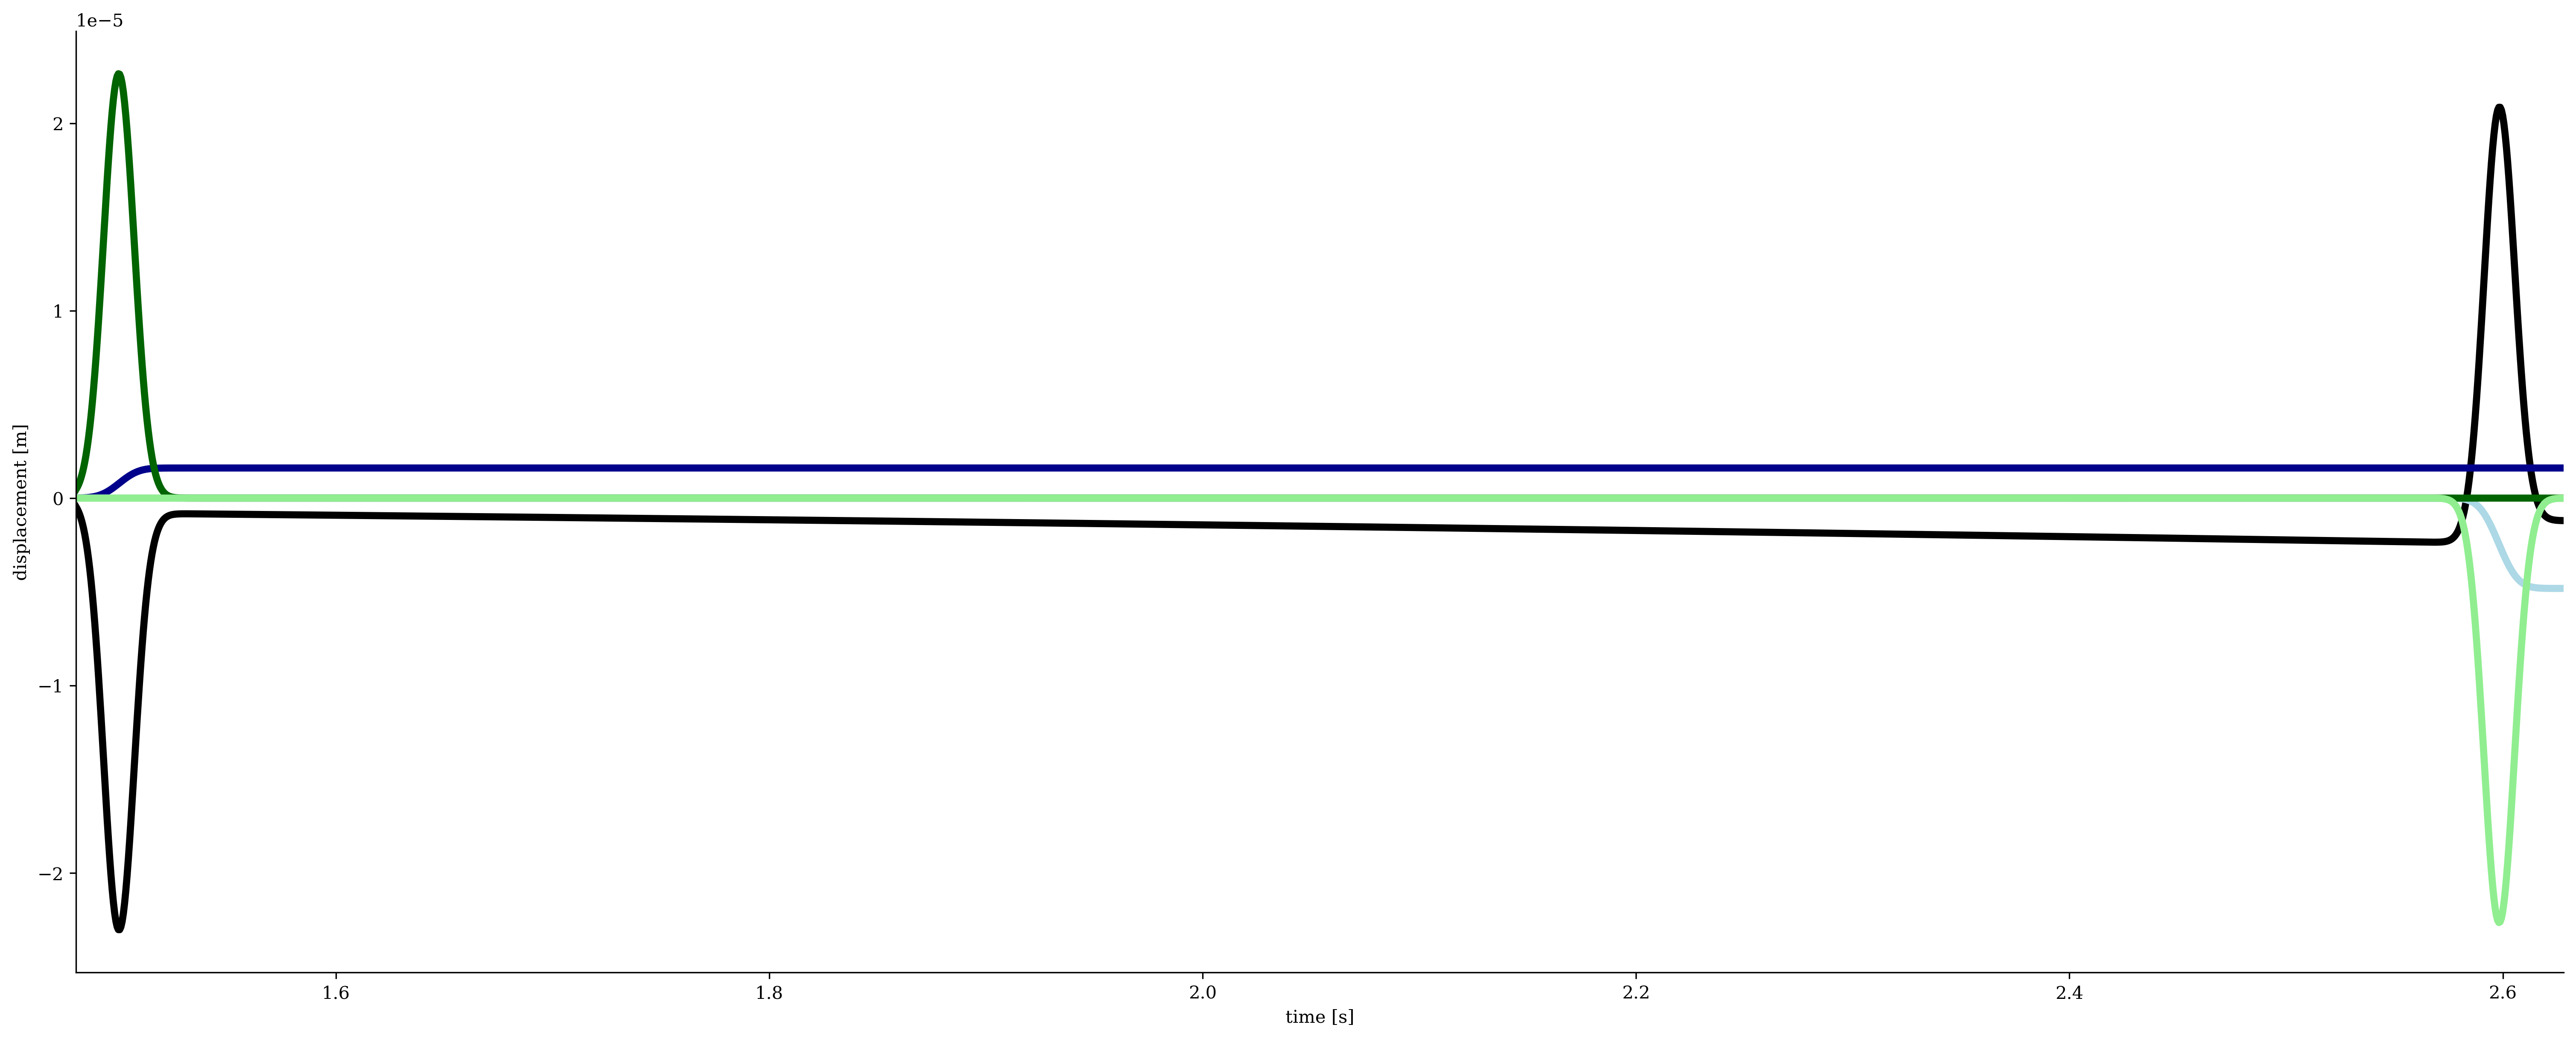

ZeroDivisionError: division by zero

In [12]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(20,8),dpi = 300,constrained_layout=True)
gs  = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0,0])
saveplot = False

t = linspace(tmin, tmax, 2000)
ax1.plot(t,U[0,:],'-',linewidth=4,color='black')


ax1.plot(t,UIPt[2,:],'-',linewidth=4,color='darkblue')
ax1.plot(t,-UISt[2,:],'-',linewidth=4,color='lightblue')

ax1.plot(t,UFPt[2,:],'-',linewidth=4,color='darkgreen')
ax1.plot(t,-UFSt[2,:],'-',linewidth=4,color='lightgreen')

### Also plot particle velocity 
# t = linspace(tmin, tmax, 1999)
# ax1.plot(t,V[2,:],'--',linewidth=4,color='black')


#set limit and axis visibility
ax1.set_xlim(tmin,tmax)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel('time [s]')
ax1.set_ylabel('displacement [m]')


             
plt.rcParams.update({'font.size': 30})  
plt.show() 
1/0


In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(20,8),dpi = 300,constrained_layout=True)
gs  = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0,0])
saveplot = False

t = linspace(tmin, tmax, 2000)
ax1.plot(t,U[0,:],'-',linewidth=4,color='black')

ax1.plot(t,UNt[2,:],'-',linewidth=4,color='red')

ax1.plot(t,UIPt[2,:],'-',linewidth=4,color='darkblue')
ax1.plot(t,-UISt[2,:],'-',linewidth=4,color='lightblue')

ax1.plot(t,UFPt[2,:],'-',linewidth=4,color='darkgreen')
ax1.plot(t,-UFSt[2,:],'-',linewidth=4,color='lightgreen')

### Also plot particle velocity 
# t = linspace(tmin, tmax, 1999)
# ax1.plot(t,V[2,:],'--',linewidth=4,color='black')


#set limit and axis visibility
ax1.set_xlim(tmin,tmax)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel('time [s]')
ax1.set_ylabel('displacement [m]')


             
plt.rcParams.update({'font.size': 30})  
plt.show() 
